In [421]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

# Control Panel: Enter the desired parameters
num_jobs = 100000
mu1_ratio = 0.8
cutoff = 50.0
# The rho used for run simulation method:
rho = 0.7

# Queue Simulator
The main simulator class of the project.


In [422]:
class QueueSimulator ():
    def __init__(self, num_jobs: int, mu1_ratio: float, cutoff: float, rho: float) -> None:
        self.num_jobs = num_jobs
        self.mu1_ratio = mu1_ratio
        self.cutoff = cutoff
        self.rho = rho
        self.mean_service_time: float = 10
        self.service_rate: float = 1 / self.mean_service_time
        self.cv_squared: float = 16

    def generate_job_sizes(self, n: int) -> np.ndarray:
        shape: float = 1 / self.cv_squared
        scale: float = self.mean_service_time * self.cv_squared
        return stats.gamma.rvs(a=shape, scale=scale, size=n)

    def simulate_mg1_fcfs(self, lambda_rate: float, num_jobs: int) -> float:
        arrivals: np.ndarray = np.random.exponential(1 / lambda_rate, num_jobs)
        service_times: np.ndarray = self.generate_job_sizes(num_jobs)
        arrival_times: np.ndarray = np.cumsum(arrivals)
        departure_times: np.ndarray = np.zeros(num_jobs)

        for i in range(num_jobs):
            if i == 0:
                departure_times[i] = arrival_times[i] + service_times[i]
            else:
                departure_times[i] = max(arrival_times[i], departure_times[i - 1]) + service_times[i]

        response_times: np.ndarray = departure_times - arrival_times
        return float(np.mean(response_times))

    def theoretical_et(self, rho: float, lambda_rate: float) -> float:
        es2 = self.mean_service_time ** 2 * (1 + self.cv_squared)
        return self.mean_service_time + (lambda_rate * es2) / (2 * (1 - rho))

    def theoretical_sita_et(self, lambda_rate: float) -> float:
        k: float = 1 / self.cv_squared
        theta: float = self.mean_service_time * self.cv_squared
        # Use gamma distribution for theoretical cutoff
        p1 = stats.gamma.cdf(cutoff, a=k, scale=theta)
        p2 = 1 - p1
        lambda1 = lambda_rate * p1
        lambda2 = lambda_rate * p2
        ES1 = stats.gamma.expect(lambda x: x, args=(k,), scale=theta, lb=0, ub=cutoff) / p1
        ES1_2 = stats.gamma.expect(lambda x: x ** 2, args=(k,), scale=theta, lb=0, ub=cutoff) / p1
        ES2 = stats.gamma.expect(lambda x: x, args=(k,), scale=theta, lb=cutoff) / p2
        ES2_2 = stats.gamma.expect(lambda x: x ** 2, args=(k,), scale=theta, lb=cutoff) / p2

        ET1 = ES1 + (lambda1 * ES1_2) / (2 * (1 - lambda1 * ES1))
        ET2 = ES2 + (lambda2 * ES2_2) / (2 * (1 - lambda2 * ES2))
        ET = p1 * ET1 + p2 * ET2
        return ET
    
    def simulate_sita(self, lambda_rate: float, given_mu1_ratio: float, cutoff: float, number_of_jobs: int) -> float:
        total_service_rate: float = self.service_rate
        mu1: float = total_service_rate * given_mu1_ratio
        
        service_times: np.ndarray = self.generate_job_sizes(number_of_jobs)
        
        server1_jobs: np.ndarray = service_times[service_times <= cutoff]
        server2_jobs: np.ndarray = service_times[service_times > cutoff]
        
        lambda1: float = lambda_rate * len(server1_jobs) / number_of_jobs
        lambda2: float = lambda_rate * len(server2_jobs) / number_of_jobs
        
        et1: float = self.simulate_server(lambda1, server1_jobs, len(server1_jobs))
        et2: float = self.simulate_server(lambda2, server2_jobs, len(server2_jobs))
        
        p1: float = len(server1_jobs) / number_of_jobs
        service_time_et: float = p1 * et1 + (1 - p1) * et2
        return service_time_et


    def simulate_server(self, lambda_rate: float, service_times: np.ndarray, number_of_jobs: int) -> float:
        arrivals: np.ndarray = np.random.exponential(1 / lambda_rate, number_of_jobs)
        arrival_times: np.ndarray = np.cumsum(arrivals)
        # Initialization of departure times to 0
        departure_times: np.ndarray = np.zeros(number_of_jobs)

        for i in range(number_of_jobs):
            if i == 0:
                departure_times[i] = arrival_times[i] + service_times[i]
            else:
                departure_times[i] = max(arrival_times[i], departure_times[i - 1]) + service_times[i]

        response_times: np.ndarray = departure_times - arrival_times
        return float(np.mean(response_times))

    def run_simulation(self) -> Tuple[float, float, float]:
        total_service_rate: float = self.service_rate
        lambda_rate: float = rho * total_service_rate

        mu1: float = total_service_rate * self.mu1_ratio
        mu2: float = total_service_rate - mu1

        mg1_et: float = self.simulate_mg1_fcfs(lambda_rate, num_jobs)
        theoretical_et: float = self.theoretical_et(rho, lambda_rate)
        sita_et: float = self.simulate_sita(lambda_rate, self.mu1_ratio, cutoff, self.num_jobs)

        return mg1_et, theoretical_et, sita_et
    
    def optimize_sita(self, rho: float, number_of_jobs: int = 10000) -> Tuple[float, float, float, float, float]:
        total_service_rate: float = 0.1 # As given by the specifications
        lambda_rate: float = rho * total_service_rate

        best_et = float('inf')
        best_mu1_ratio = 0
        best_cutoff = 0
        
        # Linspace follows conventions similar to MATLAB
        # 9 samples: 0.1, 0.2, ..., 0.9
        for temp_mu1_ratio in np.linspace(0.1, 0.9, 9):
            mu1: float = total_service_rate * temp_mu1_ratio
            mu2: float = total_service_rate - mu1
            
            # Test different cutoff values
            for temp_cutoff in np.linspace(1, 50, 50):
                sita_et: float = self.simulate_sita(lambda_rate, temp_mu1_ratio, temp_cutoff, number_of_jobs)
                if sita_et < best_et:
                    best_et = sita_et
                    best_mu1_ratio = temp_mu1_ratio
                    best_cutoff = temp_cutoff

        best_mu1 = total_service_rate * best_mu1_ratio
        theoretical_sita_et = self.theoretical_sita_et(lambda_rate)

        return best_et, theoretical_sita_et, best_mu1_ratio, best_cutoff, best_mu1


# Plotting helper methods and case specific Plotting functions
Useful for having shorter code and performing the necessary tasks to plot data.

In [423]:
def setup_plot(title: str, xlabel: str, ylabel: str, figsize: tuple = (12, 8)) -> tuple:
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    return plt.gca(), plt.gcf()


def add_second_axis(ax, x_range: np.ndarray, label: str, formatter: callable = lambda x: f'{x:.2f}'):
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    # Get the current tick locations
    ticks = ax.get_xticks()

    # Calculate the corresponding values for the second axis
    tick_labels = [formatter(x) for x in ticks * simulator.mean_service_time]
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(tick_labels)
    ax2.set_xlabel(label)
    return ax2


def plot_multiple_lines(ax, x_data: np.ndarray, y_data_list: List[np.ndarray], labels: List[str], colors: List[str],
                        styles: List[str]):
    for y_data, label, color, style in zip(y_data_list, labels, colors, styles):
        ax.plot(x_data, y_data, color=color, linestyle=style, label=label)
    ax.legend()


def plot_bar_chart(rho: float, mg1_et: float, theoretical_et: float, sita_et: float) -> None:
    ax, fig = setup_plot(f'Comparison of M/G/1/FCFS and SITA (ρ = {rho:.2f})', '', 'Mean Response Time E[T]', (10, 6))
    ax.grid(False)
    bars = ax.bar(['M/G/1/FCFS', 'SITA'], [mg1_et, sita_et], color=['#3498db', '#e74c3c'])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

    ax.axhline(y=theoretical_et, color='g', linestyle='--', label='Theoretical M/G/1/FCFS')
    ax.legend()
    plt.show()


def plot_performance(x_range: np.ndarray, y_data_list: List[np.ndarray], labels: List[str],
                     title: str, xlabel: str, ylabel: str, second_axis: bool = False) -> None:
    ax, fig = setup_plot(title, xlabel, ylabel)
    colors = ['b', 'r', 'g', 'm', 'k', 'k']
    styles = ['-', '-', '--', '--', '--', ':']

    plot_multiple_lines(ax, x_range, y_data_list, labels, colors[:len(y_data_list)], styles[:len(y_data_list)])

    if second_axis:
        add_second_axis(ax, x_range, 'Utilization (ρ)', lambda x: f'{x:.2f}')

    # Add vertical lines for λ corresponding to ρ = 0.5 and ρ = 0.9
    lambda_05 = 0.5 / simulator.mean_service_time
    lambda_09 = 0.9 / simulator.mean_service_time
    ax.axvline(x=lambda_05, color='k', linestyle='--', label='ρ = 0.5')
    ax.axvline(x=lambda_09, color='k', linestyle=':', label='ρ = 0.9')

    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_heatmap(heatmap_data: Dict[str, Union[np.ndarray, List[float]]]) -> None:
    ax, fig = setup_plot('SITA Performance Heatmap', 'Cutoff', 'μ1 Ratio')
    ax.grid(False)
    im = ax.imshow(heatmap_data['matrix'], aspect='auto', origin='lower',
                   extent=[heatmap_data['cutoffs'][0], heatmap_data['cutoffs'][-1],
                           heatmap_data['mu1_ratios'][0], heatmap_data['mu1_ratios'][-1]])
    plt.colorbar(im, label='Mean Response Time E[T]')
    plt.show()


def generate_heatmap_data(lambda_rate: float, total_service_rate: float) -> Dict[str, Union[np.ndarray, List[float]]]:
    mu1_ratios = np.linspace(0.1, 0.9, 20)
    cutoffs = np.linspace(1, 30, 20)
    performance_matrix = np.zeros((20, 20))

    for i, mr in enumerate(mu1_ratios):
        for j, c in enumerate(cutoffs):
            mu1 = total_service_rate * mr
            mu2 = total_service_rate - mu1
            performance_matrix[i, j] = simulator.simulate_sita(lambda_rate, mr, c, 1000)

    return {
        'matrix': performance_matrix,
        'mu1_ratios': mu1_ratios,
        'cutoffs': cutoffs
    }

def plot_theoretical_performance(simulator: QueueSimulator) -> None:
    """
    Plot theoretical performance for M/G/1/FCFS and SITA systems.
    """
    lambda_range = np.linspace(0.01, 0.09, 100)  # Increased resolution for smoother curves
    theoretical_mg1_values = [simulator.theoretical_et(l * simulator.mean_service_time, l) for l in lambda_range]
    theoretical_sita_values = [simulator.theoretical_sita_et(l) for l in lambda_range]

    plot_performance(lambda_range,
                     [theoretical_mg1_values, theoretical_sita_values],
                     ['M/G/1/FCFS Theoretical', 'SITA Theoretical'],
                     'Theoretical Performance Comparison',
                     'Arrival Rate (λ)',
                     'Expected Response Time E[T]',
                     second_axis=True)

def plot_improvements(rho_values, simulated_improvements, theoretical_improvements):
    ax, _ = setup_plot('SITA Improvements over M/G/1/FCFS', 'Utilization (ρ)', 'Improvement (%)', figsize=(10, 6))
    
    x = np.arange(len(rho_values))
    width = 0.35
    
    ax.bar(x - width/2, simulated_improvements, width, label='Simulated', color='#3498db')
    ax.bar(x + width/2, theoretical_improvements, width, label='Theoretical', color='#e74c3c')
    
    ax.set_xticks(x)
    ax.set_xticklabels([f'ρ = {rho}' for rho in rho_values])
    ax.legend()
    ax.set_ylim(0, 110)
    
    label_height = 20
    for i in range(len(rho_values)):
        ax.text(x[i] - width/2, label_height, f'{simulated_improvements[i]:.2f}%', 
                ha='center', va='bottom', color='white', fontweight='bold')
        ax.text(x[i] + width/2, label_height, f'{theoretical_improvements[i]:.2f}%', 
                ha='center', va='bottom', color='white', fontweight='bold')
    plt.tight_layout()
    plt.show()


# Run simulation, Prepare plot data:

In [424]:
# Create an instance of the QueueSimulator using the given parameters
simulator = QueueSimulator(num_jobs, mu1_ratio, cutoff, rho)

# Run simulation
mg1_et_rho, theoretical_et_rho, sita_et_rho = simulator.run_simulation()

# Plot performance curves
lambda_range = np.linspace(0.01, 0.09, 20)
mg1_et_values = []
sita_et_values = []
theoretical_et_values = []
theoretical_sita_et_values = []

for lambda_rate in lambda_range:
    mg1_et = simulator.simulate_mg1_fcfs(lambda_rate, num_jobs)
    sita_et = simulator.simulate_sita(lambda_rate, mu1_ratio, cutoff, num_jobs)
    theoretical_et = simulator.theoretical_et(lambda_rate * simulator.mean_service_time, lambda_rate)
    theoretical_sita_et = simulator.theoretical_sita_et(lambda_rate)

    mg1_et_values.append(mg1_et)
    sita_et_values.append(sita_et)
    theoretical_et_values.append(theoretical_et)
    theoretical_sita_et_values.append(theoretical_sita_et)
    
    # Print simulation results for experiment 1
    print(f"M/G/1/FCFS E[T]: {mg1_et:.2f}")
    print(f"Theoretical E[T]: {theoretical_et:.2f}")
    print(f"SITA E[T]: {sita_et:.2f}")


M/G/1/FCFS E[T]: 19.34
Theoretical E[T]: 19.44
SITA E[T]: 10.81
M/G/1/FCFS E[T]: 23.74
Theoretical E[T]: 24.08
SITA E[T]: 11.07
M/G/1/FCFS E[T]: 30.27
Theoretical E[T]: 29.19
SITA E[T]: 11.64
M/G/1/FCFS E[T]: 33.72
Theoretical E[T]: 34.86
SITA E[T]: 12.09
M/G/1/FCFS E[T]: 39.29
Theoretical E[T]: 41.19
SITA E[T]: 12.66
M/G/1/FCFS E[T]: 48.41
Theoretical E[T]: 48.28
SITA E[T]: 12.72
M/G/1/FCFS E[T]: 54.52
Theoretical E[T]: 56.30
SITA E[T]: 13.31
M/G/1/FCFS E[T]: 66.39
Theoretical E[T]: 65.43
SITA E[T]: 13.62
M/G/1/FCFS E[T]: 77.94
Theoretical E[T]: 75.93
SITA E[T]: 14.62
M/G/1/FCFS E[T]: 90.66
Theoretical E[T]: 88.13
SITA E[T]: 14.59
M/G/1/FCFS E[T]: 109.47
Theoretical E[T]: 102.47
SITA E[T]: 15.84
M/G/1/FCFS E[T]: 122.34
Theoretical E[T]: 119.58
SITA E[T]: 16.43
M/G/1/FCFS E[T]: 158.58
Theoretical E[T]: 140.33
SITA E[T]: 16.30
M/G/1/FCFS E[T]: 155.44
Theoretical E[T]: 166.04
SITA E[T]: 17.53
M/G/1/FCFS E[T]: 189.16
Theoretical E[T]: 198.73
SITA E[T]: 19.35
M/G/1/FCFS E[T]: 257.02
Theore

# Results-1: 
# Plot theoretical performance of M/G/1/FCFS and SITA

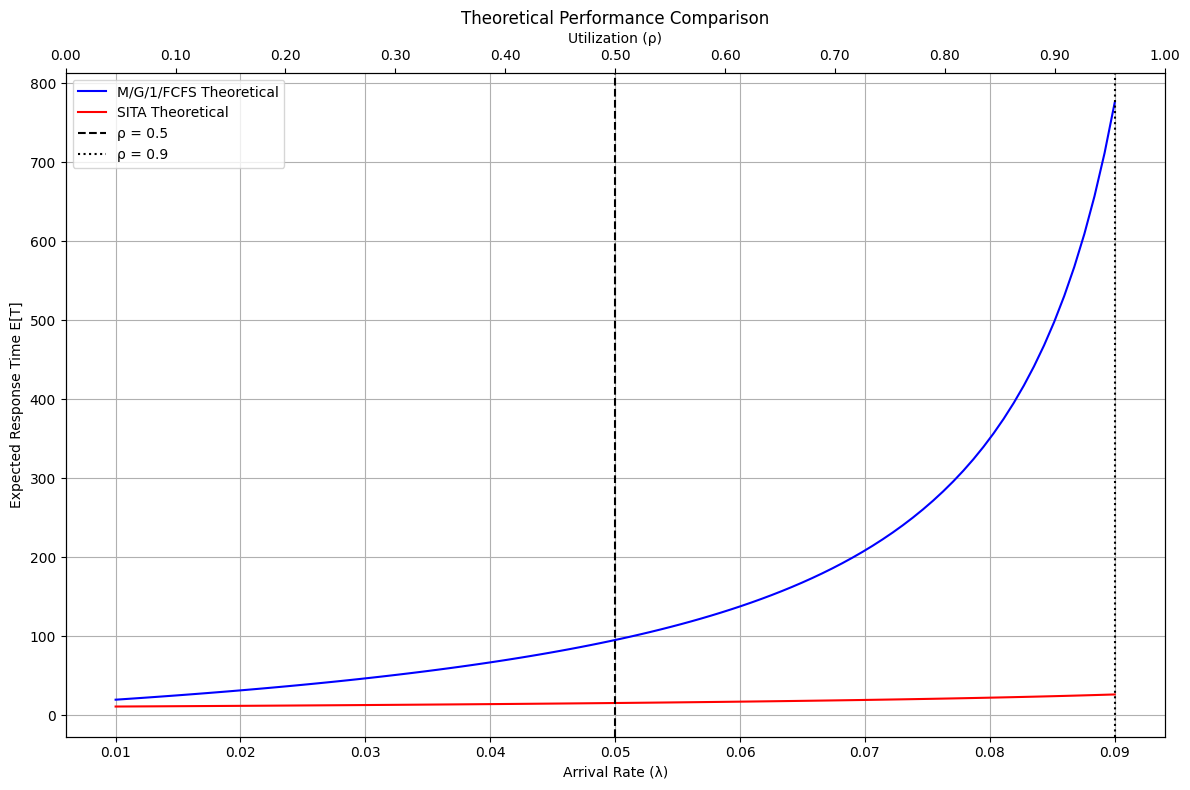

In [425]:
plot_theoretical_performance(simulator)

# Compare M/G/1/FCFS and SITA experimental expected times

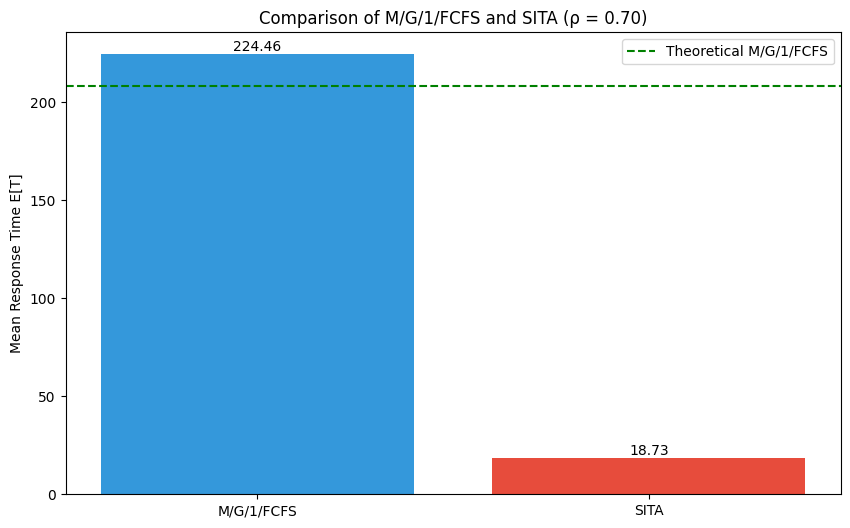

In [426]:
plot_bar_chart(rho, mg1_et_rho, theoretical_et_rho, sita_et_rho)

# Main plot. Performance of theoretical and experimental E[T] over lambda

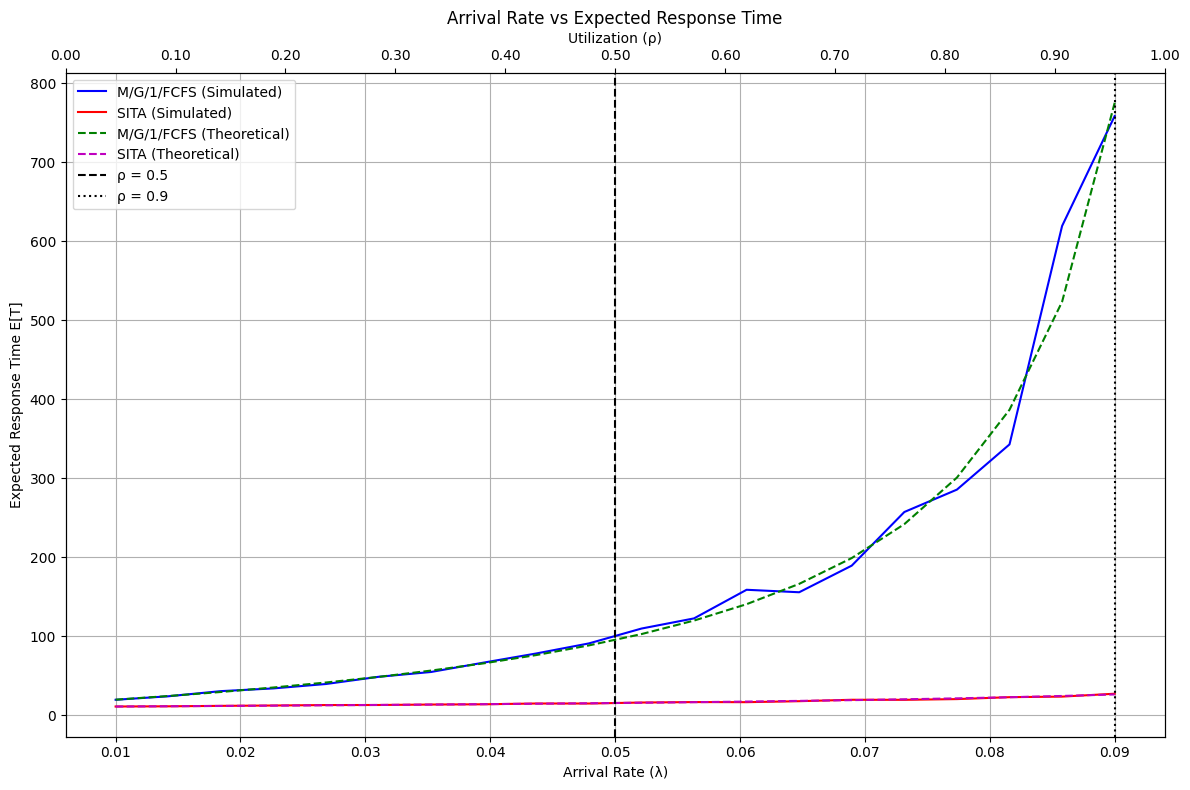

In [427]:
# The main experiment:
plot_performance(lambda_range,
                 [mg1_et_values, sita_et_values, theoretical_et_values, theoretical_sita_et_values],
                 ['M/G/1/FCFS (Simulated)', 'SITA (Simulated)', 'M/G/1/FCFS (Theoretical)', 'SITA (Theoretical)'],
                 'Arrival Rate vs Expected Response Time',
                 'Arrival Rate (λ)',
                 'Expected Response Time E[T]',
                 second_axis=True)

# Heatmap that shows good/bad combos of μ1 ratio and cutoff

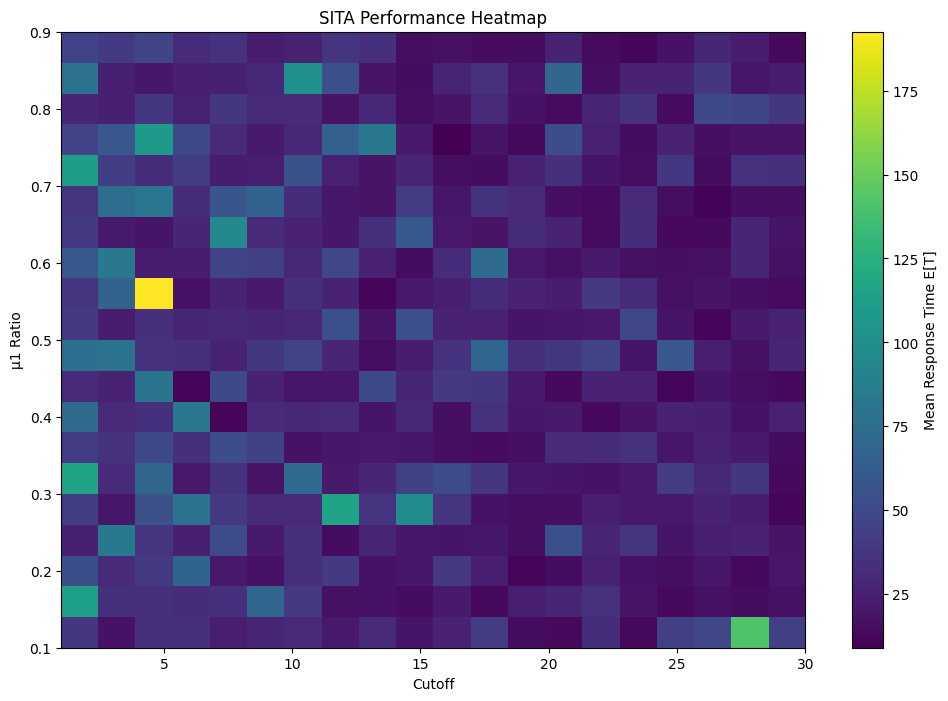

In [428]:
# Generate and plot heatmap
total_service_rate = simulator.service_rate
lambda_rate = rho * total_service_rate
heatmap_data = generate_heatmap_data(lambda_rate, total_service_rate)
plot_heatmap(heatmap_data)

# Results-2:
# Finds optimal μ1, μ2, cutoff combo 

In [429]:
# Test for ρ = 0.5 and ρ = 0.9
simulated_improvements = []
theoretical_improvements = []
rho_values = []
for test_rho in [0.5, 0.9]:
    print(f"\nResults for ρ = {test_rho}:")

    lambda_rate = test_rho * simulator.service_rate
    single_server_et = simulator.simulate_mg1_fcfs(lambda_rate, num_jobs)
    theoretical_et = simulator.theoretical_et(test_rho, lambda_rate)

    print(f"Single Server M/G/1/FCFS:")
    print(f"  Simulated E[T]: {single_server_et:.4f}")
    print(f"  Theoretical E[T]: {theoretical_et:.4f}")
    
    # SITA policy simulation
    best_sita_et, theoretical_sita_et, best_mu1_ratio, best_cutoff, best_mu1 = simulator.optimize_sita(test_rho, num_jobs)

    print(f"\nSITA Policy:")
    print(f"  Simulated E[T]: {best_sita_et:.4f}")
    print(f"  Theoretical E[T]: {theoretical_sita_et:.4f}")
    print(f"  Best μ1 ratio: {best_mu1_ratio:.4f}")
    print(f"  Best cutoff: {best_cutoff:.4f}")

    # Calculate improvements
    simulated_improvement = (single_server_et - best_sita_et) / single_server_et * 100
    theoretical_improvement = (theoretical_et - theoretical_sita_et) / theoretical_et * 100

    print(f"\nImprovements:")
    print(f"  Simulated improvement: {simulated_improvement:.2f}%")
    print(f"  Theoretical improvement: {theoretical_improvement:.2f}%")

    print("\nServer capacities:")
    print(f"  μ1: {best_mu1:.4f}")
    print(f"  μ2: {0.1-best_mu1:.4f}")

    simulated_improvements.append(simulated_improvement)
    theoretical_improvements.append(theoretical_improvement)
    rho_values.append(test_rho)


Results for ρ = 0.5:
Single Server M/G/1/FCFS:
  Simulated E[T]: 91.0752
  Theoretical E[T]: 95.0000

SITA Policy:
  Simulated E[T]: 14.3455
  Theoretical E[T]: 15.2429
  Best μ1 ratio: 0.5000
  Best cutoff: 47.0000

Improvements:
  Simulated improvement: 84.25%
  Theoretical improvement: 83.95%

Server capacities:
  μ1: 0.0500
  μ2: 0.0500

Results for ρ = 0.9:
Single Server M/G/1/FCFS:
  Simulated E[T]: 724.5895
  Theoretical E[T]: 775.0000

SITA Policy:
  Simulated E[T]: 23.3145
  Theoretical E[T]: 26.0762
  Best μ1 ratio: 0.1000
  Best cutoff: 47.0000

Improvements:
  Simulated improvement: 96.78%
  Theoretical improvement: 96.64%

Server capacities:
  μ1: 0.0100
  μ2: 0.0900


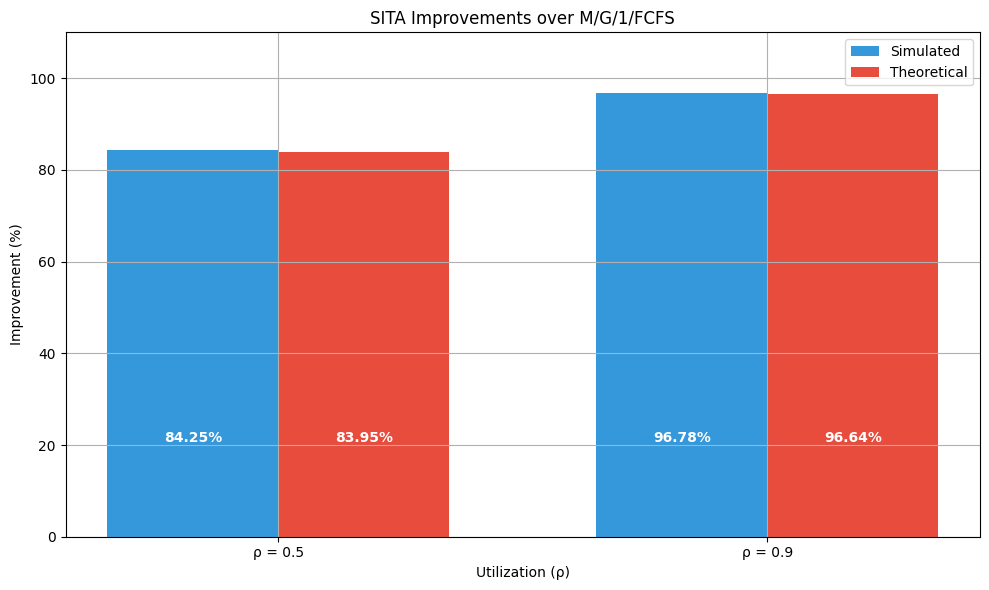

In [430]:
plot_improvements(rho_values, simulated_improvements, theoretical_improvements)